In [1]:
import pandas as pd
import numpy as np
#text preprocessing
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.models import LdaSeqModel
from gensim.models import LdaModel,LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
PYTHONHASHSEED=0 #Disable randomization

In [31]:
df = pd.read_csv("tweets&sentiment&absoluteprices.csv", index_col = 0)
req = df.loc[:,['cleaned_text','created_at']]
req = req.dropna()
req.head()

,cleaned_text,created_at
source,,
Twitter for iPhone,thank,2020-09-30 23:45:25
Twitter for iPhone,big news maine court side rnc uphold ban ballo...,2020-09-30 23:25:31
Twitter for iPhone,thank paul,2020-09-30 23:00:33
Twitter for iPhone,defective ballot new york want replace happen ...,2020-09-30 22:59:02
Twitter for iPhone,half years secure americas border rebuild awes...,2020-09-30 22:51:05


In [32]:
#See time slice quantity
print(df.loc[df['created_at']>='2020-01-01'].shape)
print(df.loc[(df['created_at']<'2020-01-01') & (df['created_at']>='2019-01-01')].shape)
print(df.loc[(df['created_at']<'2019-01-01') & (df['created_at']>='2018-01-01')].shape)
print(df.loc[(df['created_at']<'2018-01-01') & (df['created_at']>='2017-01-01')].shape)
print(df.loc[(df['created_at']<'2017-01-01') & (df['created_at']>='2016-01-01')].shape)

(9249, 27)
(7835, 27)
(3572, 27)
(2602, 27)
(4223, 27)


### Pre-process for gensim 
^ Obtained from https://radimrehurek.com/gensim_4.0.0/auto_examples/tutorials/run_lda.html

In [5]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
docs = df.cleaned_text.dropna()
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

from gensim.models import Phrases

# Add bigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 10 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

Number of unique tokens: 4090
Number of documents: 26289


In [31]:
lis = []
#keeping num of topics fixed, gridsearch
decay = [0.5,0.7,0.9]
passes = [100,200,300]
chunksize=[300,600,900]

for d in decay:
    for p in passes:
        for c in chunksize:
            model = LdaModel(
                corpus=corpus,
                id2word=id2word,
                chunksize=c,
                alpha='auto',
                eta='auto',
                decay=d,
                iterations=300,
                num_topics=10,
                passes=p,
                eval_every=None,
                random_state = 4222)
            cm = CoherenceModel(model, corpus=corpus, texts = docs,dictionary=dictionary,coherence='c_v')
            score = cm.get_coherence()
            lis.append([d,p,c,score])
            print(str('decay: %.2f, passes %d, chunksize: %d, coherence score: %.3f'%(d,p,c,score)))

decay: 0.50, passes 100, chunksize: 300, coherence score: 0.307
decay: 0.50, passes 100, chunksize: 600, coherence score: 0.350
decay: 0.50, passes 100, chunksize: 900, coherence score: 0.347
decay: 0.50, passes 200, chunksize: 300, coherence score: 0.318
decay: 0.50, passes 200, chunksize: 600, coherence score: 0.347
decay: 0.50, passes 200, chunksize: 900, coherence score: 0.353
decay: 0.50, passes 300, chunksize: 300, coherence score: 0.320
decay: 0.50, passes 300, chunksize: 600, coherence score: 0.353
decay: 0.50, passes 300, chunksize: 900, coherence score: 0.351
decay: 0.70, passes 100, chunksize: 300, coherence score: 0.336
decay: 0.70, passes 100, chunksize: 600, coherence score: 0.375
decay: 0.70, passes 100, chunksize: 900, coherence score: 0.364
decay: 0.70, passes 200, chunksize: 300, coherence score: 0.342
decay: 0.70, passes 200, chunksize: 600, coherence score: 0.373
decay: 0.70, passes 200, chunksize: 900, coherence score: 0.363
decay: 0.70, passes 300, chunksize: 300,

Best is decay: 0.90, passes 300, chunksize: 900, coherence score: 0.387

##### Now we have an idea of the optimal hyperparameter.

We enable randomness to use paralellization and find an optimal model based on:

1. Coherence score
2. Predicted topics uniformness (Use Kullback-Leibler divergence to evaluate)

In [5]:
#Enable randomness
import random
PYTHONHASHSEED = random

In [16]:
#Enable randomness
import random
PYTHONHASHSEED = random

models = []

#Uniform distribution
from scipy.stats import entropy
unif = np.full(10,0.1)

# Just compare 10 random models at 300 iterations
for i in range(10):
    model = LdaMulticore(
        workers = 7,
        corpus=corpus,
        id2word=id2word,
        chunksize=900,
        alpha='asymmetric',
        eta='auto',
        decay=0.9,
        iterations=300,
        num_topics=10,
        passes=300,
        eval_every=None,
        random_state = 4222)
    cm = CoherenceModel(model, corpus=corpus, texts = docs,dictionary=dictionary,coherence='c_v')
    score = cm.get_coherence()
    
    from copy import deepcopy
    df2 = deepcopy(df).dropna()
    topic = []
    texts = df2.cleaned_text
    for j in range(len(texts)):
        bow = dictionary.doc2bow(tokenizer.tokenize(texts[j]))
        pred = model.get_document_topics(bow,minimum_probability=0)
        pred.sort(key = lambda x: x[1],reverse = True)
        topic.append(pred[0][0] + 1)
        
    topic_prob = pd.DataFrame(topic).value_counts()/len(topic)
    divergence = entropy(unif,topic_prob)
    models.append([model,score,divergence])
    print("model %d: score: %.4f, entropy: %.4f"%(i+1,score,divergence))

model 1: score: 0.4072, entropy: 0.1485
model 2: score: 0.4141, entropy: 0.1512
model 3: score: 0.4115, entropy: 0.2079
model 4: score: 0.4177, entropy: 0.1375
model 5: score: 0.4048, entropy: 0.1651
model 6: score: 0.4168, entropy: 0.1495
model 7: score: 0.4175, entropy: 0.1371
model 8: score: 0.4229, entropy: 0.1387
model 9: score: 0.4221, entropy: 0.1740
model 10: score: 0.4107, entropy: 0.1349


#### From above, we use model 10 with the lowest entropy.

In [55]:
df2 = deepcopy(df).dropna()
topic = []
texts = df2.cleaned_text
for i in range(len(texts)):
    bow = dictionary.doc2bow(tokenizer.tokenize(texts[i]))
    pred = models[9][0].get_document_topics(bow,minimum_probability=0)
    pred.sort(key = lambda x: x[1],reverse = True)
    topic.append(pred[0][0] + 1)

In [54]:
#Save models
#import os
#filepath = os.getcwd() + "\\Coherence models"
#for i in range(10):
#    models[i][0].save(filepath+"\\model " + str(i+1))

In [33]:
#Load models
models = []
import os
filepath = os.getcwd() + "\\Coherence models"
for i in range(10):
    models.append(LdaModel.load(filepath+"\\model " + str(i+1)))

#### Attach topics

In [34]:
used_model = models[9]
from copy import deepcopy
df2 = deepcopy(df).dropna()
topic = []
texts = df2.cleaned_text
for i in range(len(texts)):
    bow = dictionary.doc2bow(tokenizer.tokenize(texts[i]))
    pred = used_model.get_document_topics(bow,minimum_probability=0)
    pred.sort(key = lambda x: x[1],reverse = True)
    topic.append(pred[0][0] + 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E473593C8>]],
      dtype=object)

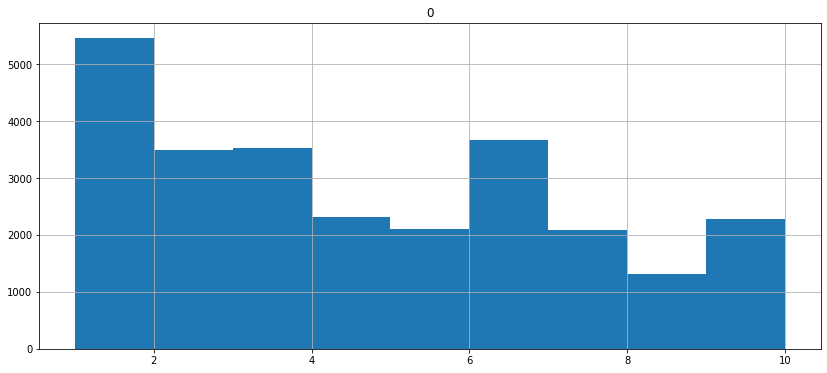

In [43]:
bins = np.arange(1,11,1)
pd.DataFrame(topic).hist(bins=bins,figsize=[14,6])

In [8]:
df2['topic'] = np.asarray(topic)
#df2.to_csv("tweets&sentiment&topic&absoluteprices.csv")

### Do the same and predict for testing data that uses Oct 2020 tweets

In [13]:
df = pd.read_csv("FinalTest_tweets&sentiment&absoluteprices.csv")

In [14]:
used_model = models[9]
from copy import deepcopy
df2 = deepcopy(df).dropna().reset_index()
topic = []
texts = df2.cleaned_text
for i in range(len(texts)):
    bow = dictionary.doc2bow(tokenizer.tokenize(texts[i]))
    pred = used_model.get_document_topics(bow,minimum_probability=0)
    pred.sort(key = lambda x: x[1],reverse = True)
    topic.append(pred[0][0] + 1)

In [15]:
bins = np.arange(1,11,1)
pd.DataFrame(topic).hist(bins=bins,figsize=[14,6])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9B7E6ADC8>]],
      dtype=object)

In [16]:
df2['topic'] = np.asarray(topic)
df2.to_csv("test_data_tweets&sentiment&topic&absoluteprices.csv")

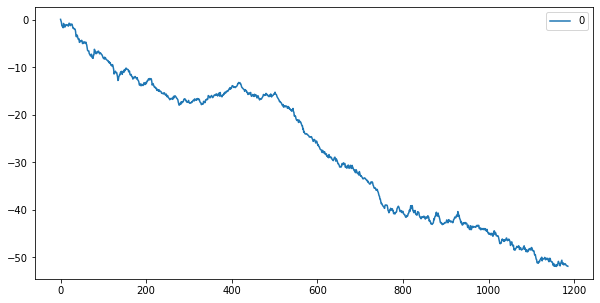

In [45]:
pd.DataFrame(results.predict(frame2)).expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (10, 5))

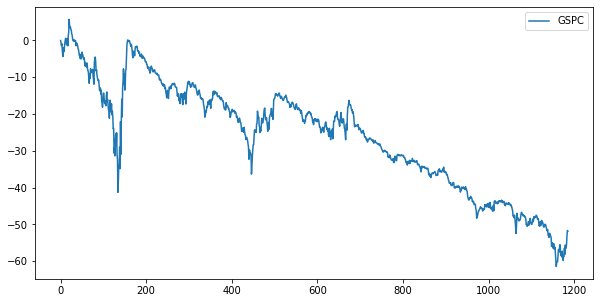

In [46]:
pd.DataFrame(np.log(pd.DataFrame(past.iloc[:,-3])/pd.DataFrame(past.iloc[:,-3].shift(1))).fillna(0)).expanding(0).apply(lambda x: sum(x) * 100, raw = True).plot(figsize = (10, 5))

In [10]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(models[9], corpus, dictionary, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  16.217783
2       0.648955  71.707100       2        1  13.854160
5      71.019684   9.971006       3        1  13.680577
1       3.785981  33.185135       4        1  13.554201
6     -42.666500  -9.222070       5        1   9.393293
4      -3.621689 -43.526516       6        1   8.864398
3      -3.632402  -4.171708       7        1   8.580767
7     -36.584400  35.804413       8        1   7.069521
9      44.391380  50.615383       9        1   4.935074
8      40.235809 -31.591665      10        1   3.850225, topic_info=         Term         Freq        Total Category  logprob  loglift
256     trump  3548.000000  3548.000000  Default  30.0000  30.0000
0       thank  2362.000000  2362.000000  Default  29.0000  29.0000
156     great  4121.000000  4121.000000  Default  28.0000  28.0000
364  american  1521.000000  1521.000000  Default  27.0000  27.0000
262      cruz   853.000000   853.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
43       maga   101.917881   404.221223  Topic10  -4.8506   1.8792
26       vote   118.536420  1476.442036  Topic10  -4.6995   0.7349
156     great   134.602269  4121.746912  Topic10  -4.5724  -0.1647
3         big   110.295260  1384.100826  Topic10  -4.7716   0.7274
225    people    95.781511  2320.954550  Topic10  -4.9127   0.0694

[638 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1792      1  0.015191   act
1792      2  0.206592   act
1792      3  0.018229   act
1792      4  0.543822   act
1792      6  0.085067   act
...     ...       ...   ...
51        7  0.009101  year
51        8  0.284419  year
51        9  0.125903  year
51       10  0.001517  year
28        6  0.997445  york

[1371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 2, 7, 5, 4, 8, 10, 9])

In [13]:
p = pyLDAvis.gensim.prepare(models[9], corpus, dictionary, mds = 'tsne')
pyLDAvis.save_html(p,'model_pyLDAvis.html')